In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import xarray as xr
import flax
import imageio
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
from sklearn.preprocessing import StandardScaler
# import equinox as eq

In [2]:
ds_grid = xr.open_zarr("/mnt/meom/workdir/johnsonj/data/qg_data/raw/temp.nc")

In [3]:
img = ds_grid.p.isel(steps=250)

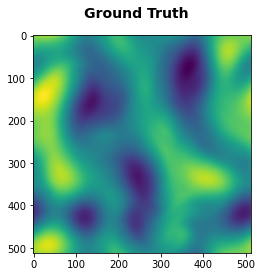

In [4]:
fig = plt.figure()
fig.suptitle('Ground Truth', fontsize=14, fontweight='bold')
plt.imshow(img)
plt.show()

In [5]:
# # Load image, take a square crop from the center
# # image_url = "https://github.com/AntonBaumannDE/fourier_features_MLP_tf2/raw/main/images/monkey.jpg"
# image_url = 'https://live.staticflickr.com/7492/15677707699_d9d67acf9d_b.jpg'
# img = imageio.imread(image_url)[..., :3] / 255.
# c = [img.shape[0]//2, img.shape[1]//2]
# r = 256
# img = img[c[0]-r:c[0]+r, c[1]-r:c[1]+r]


# losses = {}

In [6]:
# Create input pixel coordinates in the unit square
coords = jnp.stack(
    np.meshgrid(
        img.coords["Nx"].data,
        img.coords["Ny"].data
    ), -1
)


In [7]:
coords.shape, img.shape

((512, 512, 2), (512, 512))

In [8]:
coords.shape, img.shape

<xarray.DataArray 'p' (Nx: 512, Ny: 512)>
dask.array<getitem, shape=(512, 512), dtype=float64, chunksize=(64, 64), chunktype=numpy.ndarray>
Coordinates:
  * Nx       (Nx) float64 -3.142 -3.129 -3.117 -3.105 ... 3.105 3.117 3.129
  * Ny       (Ny) float64 -3.142 -3.129 -3.117 -3.105 ... 3.105 3.117 3.129
    steps    int64 250

In [99]:
# Create input pixel coordinates in the unit square
# coords = np.linspace(0, 1, img.shape[0], endpoint=False)
# x_test = np.stack(np.meshgrid(coords, coords), -1)
test_data = [jnp.asarray(coords), jnp.asarray(img.data)]
factor = 5
train_data = [jnp.asarray(coords[::factor,::factor]), jnp.asarray(img.data[::factor,::factor][..., None])]

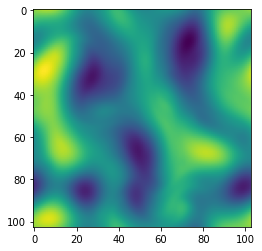

In [100]:
fig, ax = plt.subplots()

ax.imshow(train_data[1])

plt.show()

In [57]:
train_data[0].shape, train_data[0].shape, test_data[0].shape, test_data[0].shape

((35, 35, 2), (35, 35, 2), (512, 512, 2), (512, 512, 2))

In [58]:
from flax import linen as nn

class MLP(nn.Module):
    """A simple MLP model."""

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=1)(x)
        # x = nn.sigmoid(x)
        return x

In [59]:


# initialize model
model = MLP()
# get demo data
batch = train_data[0]

variables = model.init(jax.random.PRNGKey(0), batch)
output = model.apply(variables, batch)

In [60]:
losses = {}

In [61]:

# assert features.shape == (batch.shape[0],batch.shape[1],mapping_size*2)

In [62]:
# Same as JAX version but using model.apply().
# def mse(params, x_batched, y_batched):
#     # Define the squared loss for a single pair (x,y)
#     def squared_error(x, y):
#         pred = model.apply(params, x)
#         return jnp.inner(y-pred, y-pred) / 2.0
#     # Vectorize the previous to compute the average of the loss on all samples.
#     return jnp.mean(jax.vmap(squared_error)(x_batched,y_batched), axis=0)


def mse(params, x, y):
    
    # error
    diff = model.apply(params, x) - y
    
    # mean squared error
    return jnp.mean(diff ** 2)

In [64]:
import optax
alpha = 1e-4
tx = optax.adam(learning_rate=alpha)
opt_state = tx.init(variables)
loss_grad_fn = jax.jit(jax.value_and_grad(mse))

In [65]:
train_data[0].shape, train_data[1].shape

((35, 35, 2), (35, 35, 1))

In [66]:
loss, grad = loss_grad_fn(variables, train_data[0], train_data[1])

In [67]:
losses["mlp"] = []
iterations = 2_000

with tqdm.trange(iterations) as pbar:
    for i in pbar:
        loss_val, grads = loss_grad_fn(variables, train_data[0], train_data[1])
        updates, opt_state = tx.update(grads, opt_state)
        variables = optax.apply_updates(variables, updates)
        pbar.set_description(f'Loss step {i}: {loss_val:.4f}')
        losses["mlp"].append(loss_val)

  0%|          | 0/2000 [00:00<?, ?it/s]

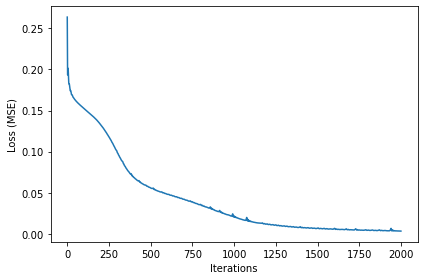

In [68]:
fig, ax = plt.subplots()

ax.plot(losses["mlp"])
ax.set(xlabel="Iterations", ylabel="Loss (MSE)")
plt.tight_layout()
plt.show()

In [69]:
outputs = model.apply(variables, test_data[0])

In [70]:
test_data[0].shape

(512, 512, 2)

In [72]:
outputs.shape, img.shape

((512, 512, 1), (512, 512))

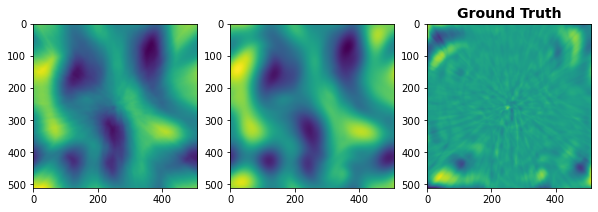

In [75]:
fig, axs = plt.subplots(figsize=(10,10), ncols=3)
plt.title('Ground Truth', fontsize=14, fontweight='bold')
axs[0].imshow(outputs)
axs[1].imshow(img)
axs[2].imshow(img - outputs.squeeze())
plt.show()

## Fourier Features

In [101]:
# Fourier feature mapping
def input_mapping(x, B): 
    if B is None:
        return x
    else:
        x_proj = (2.*np.pi*x) @ B.T
    return np.concatenate([np.sin(x_proj), np.cos(x_proj)], axis=-1)

In [102]:
rand_key = jax.random.PRNGKey(123)
mapping_size = 256
scale = 10

# generate random features
B = jax.random.normal(rand_key, (mapping_size, 2))
B *= scale

# transform to features
batch = train_data[0]
features = input_mapping(batch, B)

# check shape
features.shape

(103, 103, 512)

In [109]:

# initialize model
model = MLP()
# get demo data

variables = model.init(jax.random.PRNGKey(0), features)
output = model.apply(variables, features)

In [110]:
import optax
alpha = 1e-4
tx = optax.adam(learning_rate=alpha)
opt_state = tx.init(variables)
loss_grad_fn = jax.jit(jax.value_and_grad(mse))

In [111]:
losses["rff"] = []
iterations = 2_000

with tqdm.trange(iterations) as pbar:
    for i in pbar:
        loss_val, grads = loss_grad_fn(variables, features, train_data[1])
        updates, opt_state = tx.update(grads, opt_state)
        variables = optax.apply_updates(variables, updates)
        pbar.set_description(f'Loss step {i}: {loss_val:.4e}')
        losses["rff"].append(loss_val)

  0%|          | 0/2000 [00:00<?, ?it/s]

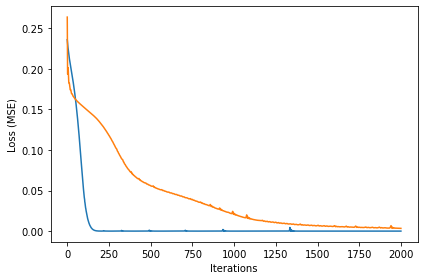

In [112]:
fig, ax = plt.subplots()

ax.plot(losses["rff"])
ax.plot(losses["mlp"])
ax.set(xlabel="Iterations", ylabel="Loss (MSE)",)
plt.tight_layout()
plt.show()

In [113]:


features_test = input_mapping(test_data[0], B)
outputs = model.apply(variables, features_test)

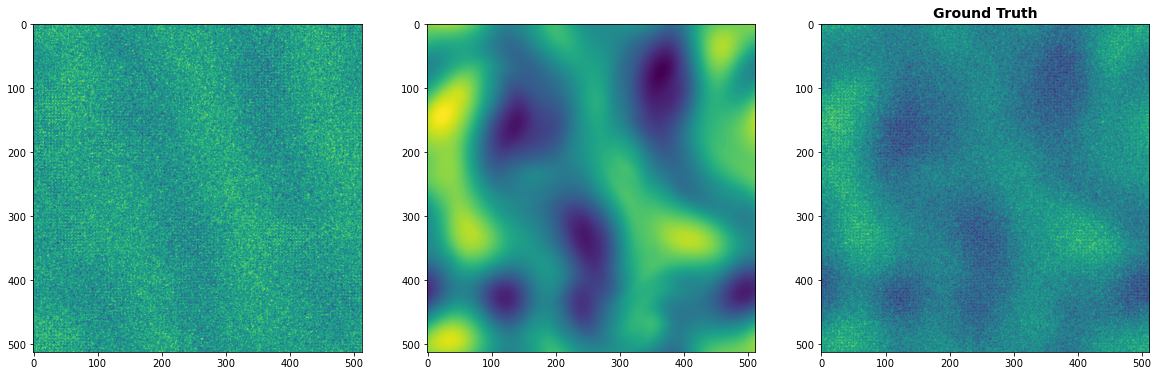

In [114]:
fig, axs = plt.subplots(figsize=(20,20), ncols=3)
plt.title('Ground Truth', fontsize=14, fontweight='bold')
axs[0].imshow(outputs)
axs[1].imshow(img)
axs[2].imshow(img - outputs.squeeze())
plt.show()

In [32]:
batch.shape, features.shape

((256, 256, 2), (256, 256, 512))